# Predictive analysis of Bank Marketing
_Taken from [here](https://www.kaggle.com/code/kevalm/xgboost-implementation-on-bank-marketing-dataset?scriptVersionId=2074012)_

#### Problem Statement
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

#### What to achieve?
The classification goal is to predict if the client will subscribe a term deposit (variable y).

#### Data Contains information in following format:

### Categorical Variable :

* Marital - (Married , Single , Divorced)",
* Job - (Management,BlueCollar,Technician,entrepreneur,retired,admin.,services,selfemployed,housemaid,student,unemployed,unknown)
* Contact - (Telephone,Cellular,Unknown)
* Education - (Primary,Secondary,Tertiary,Unknown)
* Month - (Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec)
* Poutcome - (Success,Failure,Other,Unknown)
* Housing - (Yes/No)
* Loan - (Yes/No)
* Default - (Yes/No)

### Numerical Variable:

* Age
* Balance
* Day
* Duration
* Campaign
* Pdays
* Previous

#### Class
* deposit - (Yes/No)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Loading
The target column is 'y'.

In [3]:
#Importing and displaying data
bank_marketing_raw_data = fetch_ucirepo(id=222)

bank_marketing_features_df = bank_marketing_raw_data.data.features

bank_marketing_target_df = bank_marketing_raw_data.data.targets

bank_marketing_raw_data_df = bank_marketing_features_df.join(bank_marketing_target_df)
bank_marketing_raw_data_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no
5,35,management,married,tertiary,no,231,yes,no,NaN,5,may,139,1,-1,0,NaN,no
6,28,management,single,tertiary,no,447,yes,yes,NaN,5,may,217,1,-1,0,NaN,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,NaN,5,may,380,1,-1,0,NaN,no
8,58,retired,married,primary,no,121,yes,no,NaN,5,may,50,1,-1,0,NaN,no
9,43,technician,single,secondary,no,593,yes,no,NaN,5,may,55,1,-1,0,NaN,no


In [4]:
#4521 rows and 17 features
bank_marketing_raw_data_df.shape

(45211, 17)

In [5]:
#datatypes of the columns
bank_marketing_raw_data_df.dtypes

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

# Preprocessing

Since the dtype contains types other than numerical, we need to convert those column values into proper format in order to fit the data in our model (XGBoost).

In [6]:
object_feature_cols = bank_marketing_raw_data_df.select_dtypes(include='object').columns.drop('y', errors='ignore').values

object_feature_cols

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'poutcome'], dtype=object)

In [7]:
#Converting object type data into numeric type using One-Hot encoding method which is
#majorly used for XGBoost (for better accuracy) [Applicable only for non numeric categorical features]
bank_marketing_dummy_df = pd.get_dummies(bank_marketing_raw_data_df, columns=object_feature_cols)

In [8]:
#Since y is a class variable we will have to convert it into binary format. (Since 2 unique class values)
bank_marketing_dummy_df.replace(to_replace={'y': {'yes': 1, 'no': 0}}, inplace=True)

C:\Users\LinetsM\AppData\Local\Temp\ipykernel_28300\3387141594.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank_marketing_dummy_df.replace(to_replace={'y': {'yes': 1, 'no': 0}}, inplace=True)


In [9]:
#Checking types of all the columns converted
bank_marketing_dummy_df.dtypes

age                    int64
balance                int64
day_of_week            int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                      int64
job_admin.              bool
job_blue-collar         bool
job_entrepreneur        bool
job_housemaid           bool
job_management          bool
job_retired             bool
job_self-employed       bool
job_services            bool
job_student             bool
job_technician          bool
job_unemployed          bool
marital_divorced        bool
marital_married         bool
marital_single          bool
education_primary       bool
education_secondary     bool
education_tertiary      bool
default_no              bool
default_yes             bool
housing_no              bool
housing_yes             bool
loan_no                 bool
loan_yes                bool
contact_cellular        bool
contact_telephone       bool
month_apr               bool
month_aug     

In [10]:
#Our New dataframe ready for XGBoost
bank_marketing_dummy_df.head()

,age,balance,day_of_week,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,58,2143,5,261,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,False
1,44,29,5,151,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,False
2,33,2,5,76,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,False
3,47,1506,5,92,1,-1,0,0,False,True,...,False,False,False,True,False,False,False,False,False,False
4,33,1,5,198,1,-1,0,0,False,False,...,False,False,False,True,False,False,False,False,False,False


In [11]:
#Spliting data as X -> features and y -> class variable
data_y = pd.DataFrame(bank_marketing_dummy_df['y'])
data_X = bank_marketing_dummy_df.drop(['y'], axis=1)
print(data_X.columns)
print(data_y.columns)

Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success'],
      dtype='object')
Index(['y'], dtype='object')


# Train-Test Split

In [12]:
#Dividing records in training and testing sets along with its shape (rows, cols)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(31647, 47)
(13564, 47)
(31647, 1)
(13564, 1)


# Training XGBoost Classifier from xgboost Library

In [13]:
#Create an XGB classifier and train it on 70% of the data set.
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
y_pred = clf.predict(X_test)

## Performance

In [16]:
#classification accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.9054113830728399


# Training DMatrix Classifier Using xgboost Library

In [17]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [18]:
watchlist = [(dtrain, 'train'),(dtest, 'val')]
print(watchlist)

[(<xgboost.core.DMatrix object at 0x0000014DB3120310>, 'train'), (<xgboost.core.DMatrix object at 0x0000014DB3120370>, 'val')]


In [19]:
#Train the model
params = {
    'objective':'multi:softprob',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

In [20]:
XGB_Model = xgb.train(params,dtrain,num_rounds)

C:\ProgramData\miniconda3\envs\mlops\lib\site-packages\xgboost\core.py:158: UserWarning: [10:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_dept", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
from pathlib import Path

XGB_Model.save_model(Path('.').absolute().parent/'modeling'/'baseline_bank_marketing.json')

In [22]:
predicted_probas = XGB_Model.predict(dtest)
# print(predicted_probas)

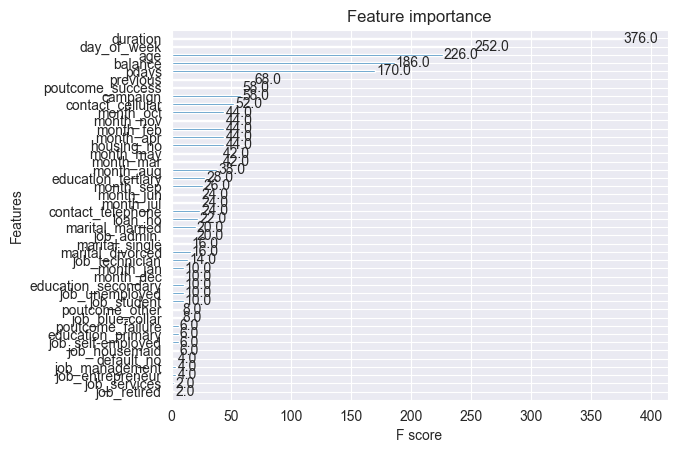

In [23]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(XGB_Model)
pyplot.show()

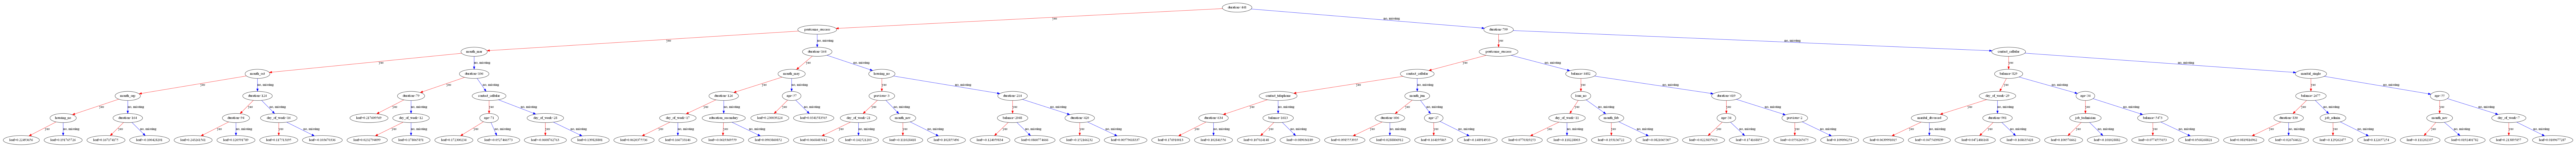

In [24]:
#Tree visualisation (Double tap to zoo)
xgb.plot_tree(XGB_Model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig(Path('.').absolute().parent.parent/'Docs'/'Models'/'Baseline'/'baseline_bank_marketing_tree.png', dpi=300, bbox_inches='tight')

## Performance

### Accuracy

In [25]:
print(metrics.accuracy_score(y_test, np.argmax(predicted_probas, axis=1)))

0.9076231200235919


### AUC ROC

In [29]:
y_test

,y
28922,0
23656,0
33315,0
7183,0
41142,0
...,...
16695,0
13189,0
24447,0
13117,0


In [32]:
from sklearn.metrics import roc_auc_score

predicted_proba_of_positive = predicted_probas[:, 1]
roc_auc_score_val = roc_auc_score(y_test, predicted_proba_of_positive)
print(f"ROC AUC score: {roc_auc_score_val}")

ROC AUC score: 0.9294707052200818
